In [1]:
import os
import random

import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from collections import defaultdict
from route_networks import SiameseNet, TripletNet
from route_hold_dataset import RouteMatching, create_hold_dataset
from utils import create_dataset_dicts, plot_routes

# Training

In [3]:
d_dict_train = create_dataset_dicts(f"../data/bh/train", skip_no_routes=True)
# create_hold_dataset(d_dict_train)

## Train Siamese Net

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
siamese_model = SiameseNet().to(device)
# Uncomment to load existing model
# siamese_model.load_state_dict(torch.load("siamese_network_resnet50_frozen_adamw_1e-3.pt"))
# Uncomment to freeze resnet parameters
# for param in siamese_model.resnet.parameters():
#    param.requires_grad = False

In [9]:
augmentations = T.Compose(
    [
        T.RandomVerticalFlip(),
        T.RandomHorizontalFlip(),
        T.RandomApply([T.RandomRotation((90, 90))]),
    ]
)
train_dataset = RouteMatching(
    dataset_dict=d_dict_train,
    transform=T.Compose([siamese_model.preprocess, augmentations]),
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16)

In [ ]:
siamese_model.train()
optimizer = optim.AdamW(siamese_model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

for epoch in range(100):
    running_loss = []
    correct = 0
    total = 0
    for img1, img2, targets in tqdm(train_loader):
        img1, img2, targets = img1.to(device), img2.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = siamese_model(img1, img2).squeeze()
        loss = criterion(outputs, targets)
        pred = torch.where(outputs > 0.5, 1, 0)
        correct += pred.eq(targets.view_as(pred)).sum().item()
        total += outputs.shape[0]
        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().detach().numpy())
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} - Loss: {np.mean(running_loss):.4f} - Acc: {correct/total}"
        )

In [11]:
torch.save(
    siamese_model.state_dict(),
    "siamese_network_resnet50_frozen_adamw_1e-3_finetuned-adamw_1e-5.pt",
)

## Train TripletNet

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
triplet_model = TripletNet().to(device)
# Uncomment to load existing model
# triplet_model.load_state_dict(
#     torch.load("triplet_network_resnet50_full_200_adamw_1e-3_triplet_mining1e-5.pt")
# )
# Uncomment to freeze resnet parameters
# for param in triplet_model.resnet.parameters():
#     param.requires_grad = False

In [5]:
augmentations = T.Compose(
    [
        T.RandomVerticalFlip(),
        T.RandomHorizontalFlip(),
        T.RandomApply([T.RandomRotation((90, 90))]),
    ]
)
train_dataset = RouteMatching(
    dataset_dict=d_dict_train,
    transform=T.Compose([triplet_model.preprocess, augmentations]),
    triplet=True,
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

In [24]:
# Triplet Mining experiment
def select_hardest(loss_values):
    if loss_values.max() == 0:
        return -1
    return torch.argmax(loss_values)


def select_random(loss_values):
    if loss_values.max() == 0:
        return -1
    return torch.randint(0, len(loss_values), (1,), dtype=torch.long)[0]


def select_semihard(loss_values, margin=1):
    idxs = torch.nonzero(
        (loss_values.view(-1) < margin) & (loss_values.view(-1) > 0)
    ).view(-1)
    if len(idxs) == 0:
        return -1
    choice = torch.randint(0, len(idxs), (1,), dtype=torch.long)[0]
    return idxs[choice]

In [ ]:
triplet_model.train()

optimizer = optim.AdamW(triplet_model.parameters(), lr=1e-5)
criterion = nn.TripletMarginLoss(reduction="none")

for epoch in range(100):
    running_loss = []
    correct = 0
    total = 0
    for img1, img2, img3 in tqdm(train_loader):
        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
        optimizer.zero_grad()
        # Uncomment for triplet mining experiment
        # with torch.no_grad():
        #     output1 = triplet_model(img1)
        #     output2 = triplet_model(img2)
        #     output3 = triplet_model(img3)
        #     loss = criterion(output1, output2, output3)
        #     ids = torch.tensor([select_hardest(loss), select_random(loss), select_semihard(loss)])
        #     ids = ids[ids>=0]
        #     img1 = img1[ids]
        #     img2 = img2[ids]
        #     img3 = img3[ids]
        output1 = triplet_model(img1)
        output2 = triplet_model(img2)
        output3 = triplet_model(img3)
        loss = criterion(output1, output2, output3).mean()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            pos_dist = nn.functional.pairwise_distance(output1, output2).square()
            neg_dist = nn.functional.pairwise_distance(output1, output3).square()
            correct += (pos_dist < neg_dist).sum().item()
        total += output1.shape[0]
        running_loss.append(loss.cpu().detach().numpy())
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} - Loss: {np.mean(running_loss):.4f} : Acc: {correct/total}"
        )

In [17]:
torch.save(
    triplet_model.state_dict(),
    "triplet_network_resnet50_full_200_adamw_1e-3_triplet_mining.pt",
)

# Testing

In [3]:
d_dict_test = create_dataset_dicts(f"../data/bh/test", skip_no_routes=True)
# create_hold_dataset(d_dict_test)

## Test SiameseNet

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
siamese_model = SiameseNet().to(device)
siamese_model.load_state_dict(
    torch.load("siamese_network_resnet50_frozen_adamw_1e-3_finetuned-adamw_1e-5.pt")
)
random.seed(42)
test_dataset = RouteMatching(
    dataset_dict=d_dict_test,
    transform=T.Compose([siamese_model.preprocess]),
    triplet=False,
    augment_colors=False,
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


0.6695652173913044
defaultdict(<class 'list'>, {0: [38, 7, 13, 33, 35, 37, 41, 45], 1: [0, 2, 11, 15, 24, 26, 39, 42], 2: [4, 6, 9, 10, 12, 14, 21, 46, 48], 3: [5, 23], 4: [8, 17, 19], 5: [18, 20, 22, 25, 34, 40], 6: [27, 29, 30], 7: [31], 8: [32], 9: [36, 44]})
defaultdict(<class 'list'>, {0: [3, 0, 1, 4, 10, 23, 39, 42, 43, 64], 1: [2, 5, 12, 26, 27, 32, 33, 34], 2: [6, 11, 24, 36, 40, 49, 52, 53, 54, 73, 74], 3: [7, 8, 31], 4: [9, 35, 37, 38, 44, 59], 5: [13, 14, 16, 17, 18, 20, 50], 6: [15, 25, 58, 62, 68], 7: [19, 21, 22, 28, 30], 8: [29, 41, 69, 71], 9: [45, 46], 10: [47, 51, 57, 61, 66, 67], 11: [48, 72], 12: [60, 63], 13: [65]})


/home/philipp/Studium/ws2022/Hei-CV-Final-2022-23/ml/utils.py:232: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=2)


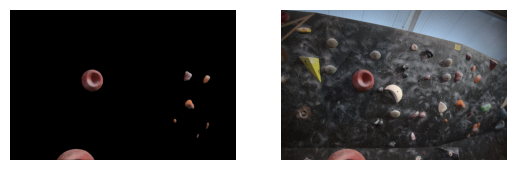

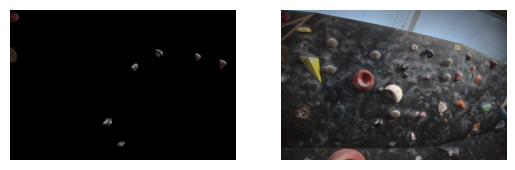

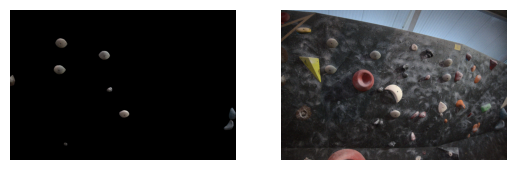

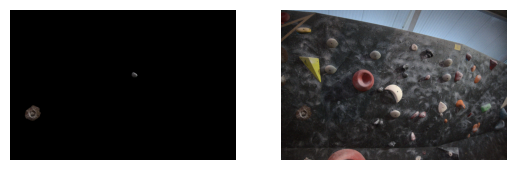

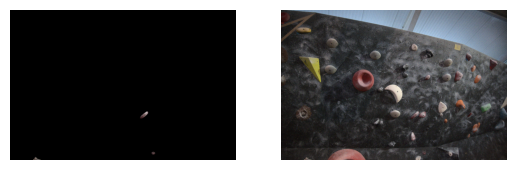

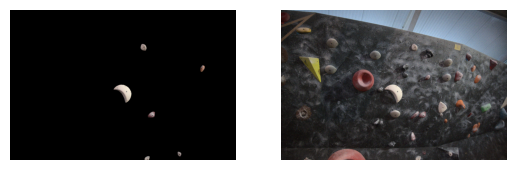

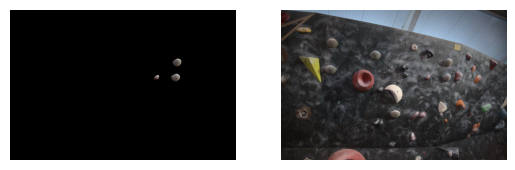

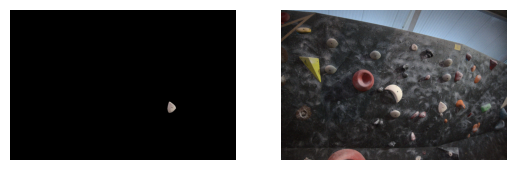

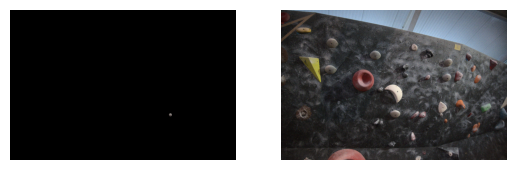

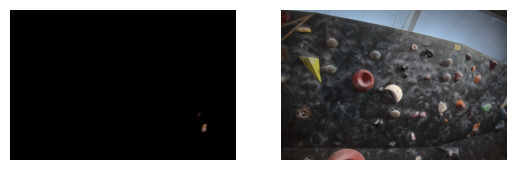

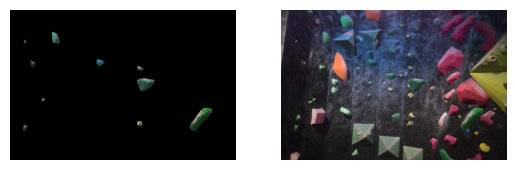

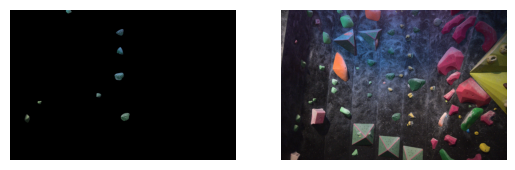

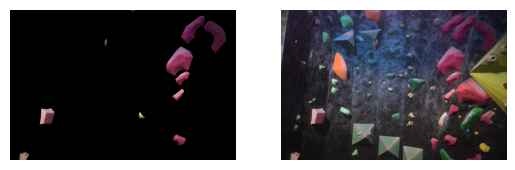

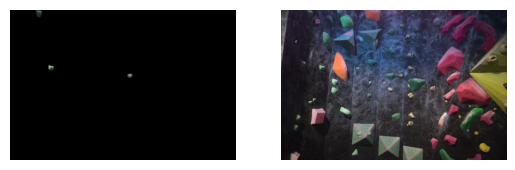

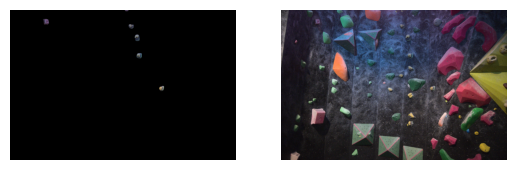

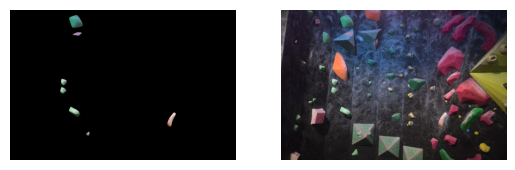

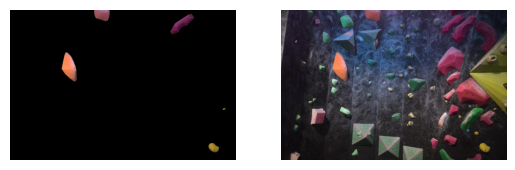

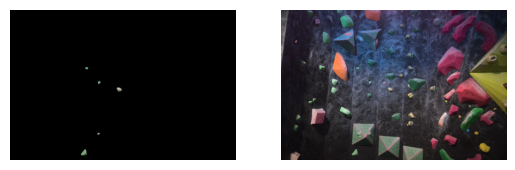

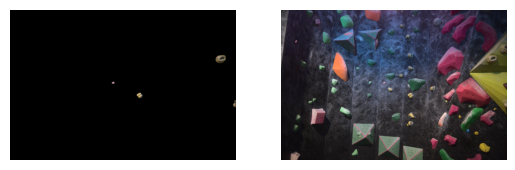

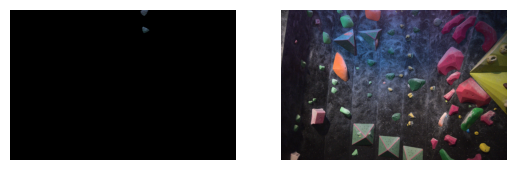

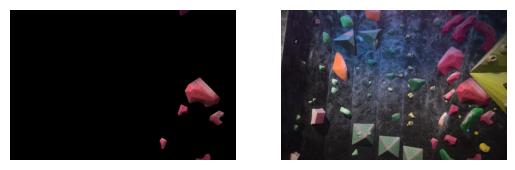

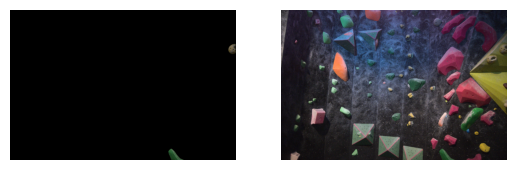

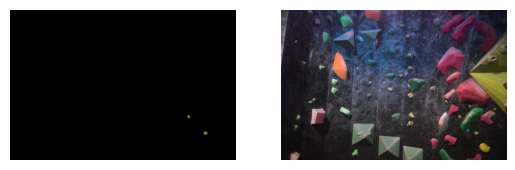

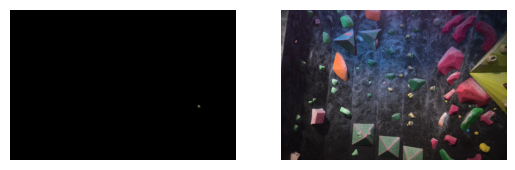

In [5]:
siamese_model.eval()


def hold_from_ids(read_path, image_idx, hold_idx):
    hold = cv2.imread(os.path.join(*read_path, "holds", f"{image_idx}-{hold_idx}.jpg"))
    hold = torch.tensor(hold).permute(2, 0, 1)
    hold = siamese_model.preprocess(hold).to(device).unsqueeze(0)
    return hold


correct = 0
total = 0
for img1, img2, targets in tqdm(test_loader):
    with torch.no_grad():
        img1, img2, targets = img1.to(device), img2.to(device), targets.to(device)
        outputs = siamese_model(img1, img2).squeeze()
        pred = torch.where(outputs > 0.5, 1, 0)
        correct += pred.eq(targets.view_as(pred)).sum().item()
    total += outputs.shape[0]

print(correct / total)

for image_idx, image_obj in enumerate(d_dict_test):
    read_path = image_obj["file_name"].split("/")[:-1]
    routes_dict = defaultdict(list)
    valid_hold_idx = []
    for hold_idx, poly in enumerate(image_obj["annotations"]):
        if poly["category_id"] == 1:
            # Volumes are considered part of the wall, not part of a route -> skip
            continue
        if poly["route_id"] is None:
            continue
        valid_hold_idx.append(hold_idx)

    start_node_idx = random.choice(valid_hold_idx)
    routes_dict[0] = [start_node_idx]
    for hold_idx, poly in enumerate(image_obj["annotations"]):
        if poly["category_id"] == 1:
            # Volumes are considered part of the wall, not part of a route -> skip
            continue
        if poly["route_id"] is None:
            continue
        if hold_idx == start_node_idx:
            continue
        for route_id, holds in routes_dict.items():
            preds = []
            for random_hold_idx in holds:
                with torch.no_grad():
                    outputs = siamese_model(
                        hold_from_ids(read_path, image_idx, hold_idx),
                        hold_from_ids(read_path, image_idx, random_hold_idx),
                    )
                pred = torch.where(outputs > 0.5, 1, 0).item()
                preds.append(pred)
            if all(preds):
                # Current hold is similar to all holds in existing route => Adding it to that route
                routes_dict[route_id].append(hold_idx)
                break
        else:
            # Current hold is not similar to any holds on existing routes => Add new route
            routes_dict[max(routes_dict.keys()) + 1].append(hold_idx)
    print(routes_dict)
    figures_axes = plot_routes(routes_dict, image_obj)
    for fig, ax in figures_axes:
        fig.canvas.draw()

## Test TripletNet

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
triplet_model = TripletNet().to(device)
triplet_model.load_state_dict(
    torch.load("triplet_network_resnet50_full_200_adamw_1e-3_triplet_mining1e-5.pt")
)
random.seed(42)
test_dataset = RouteMatching(
    dataset_dict=d_dict_test,
    transform=T.Compose([triplet_model.preprocess]),
    triplet=True,
    augment_colors=False,
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


0.8173913043478261
defaultdict(<class 'list'>, {0: [38, 0, 2, 7, 33, 35, 37, 40, 41, 44, 45], 1: [4, 5, 6, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26, 27, 29, 30, 32, 39, 46, 48], 2: [8, 18, 21, 22, 31, 34], 3: [13, 20, 42], 4: [19], 5: [36]})
defaultdict(<class 'list'>, {0: [3, 2, 4, 5, 7, 10, 13, 19, 20, 21, 22, 26, 27, 28, 31, 32, 33, 36, 39, 42, 44, 45, 48, 65], 1: [0, 6, 15, 25, 29, 47, 49, 51, 52, 53, 54, 57, 61, 66, 67, 73], 2: [1, 8, 12, 18, 23, 24, 30, 34, 35, 37, 38, 43, 46, 59], 3: [9, 11], 4: [14, 16, 17, 50], 5: [40, 41], 6: [58, 60, 62, 63, 68, 71, 72, 74], 7: [64], 8: [69]})


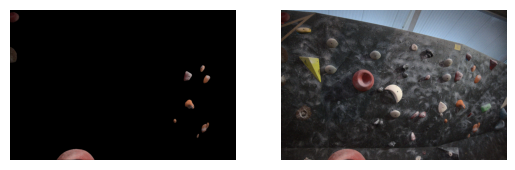

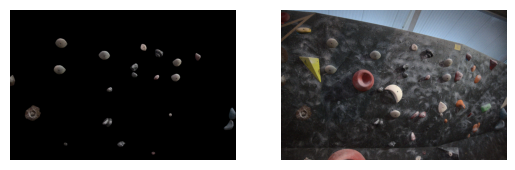

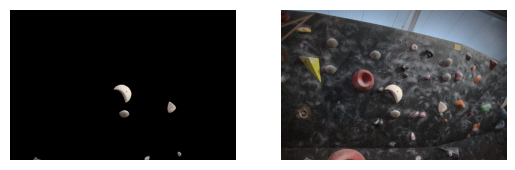

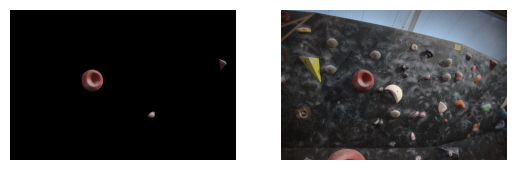

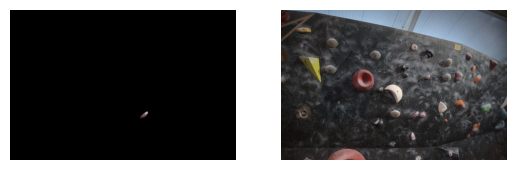

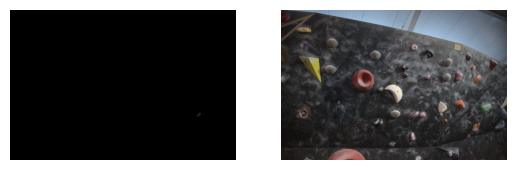

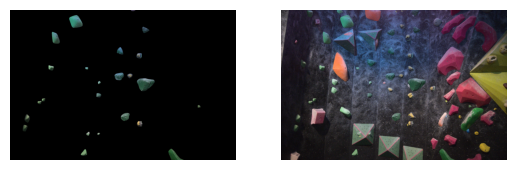

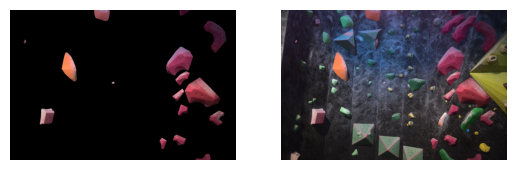

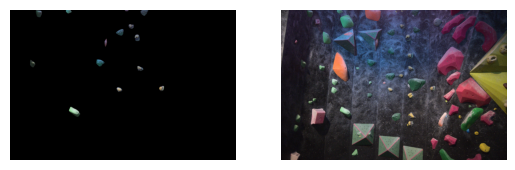

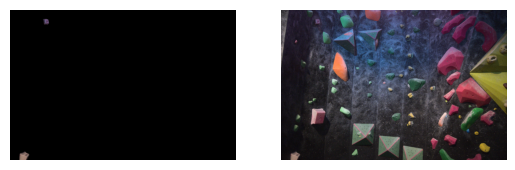

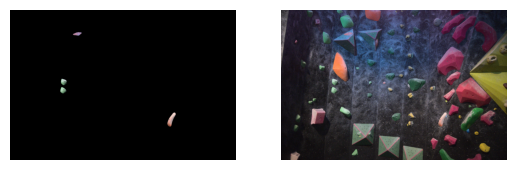

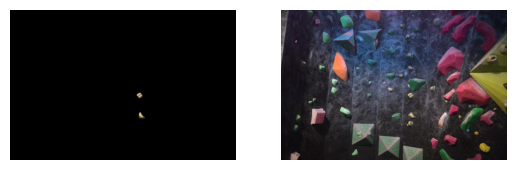

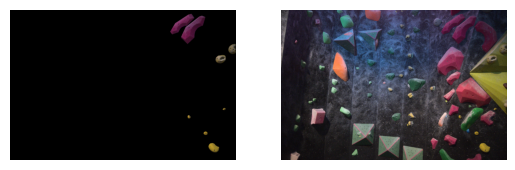

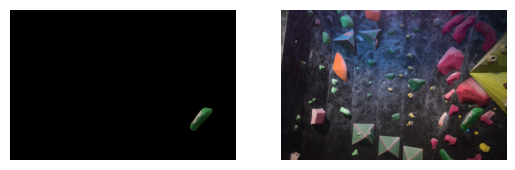

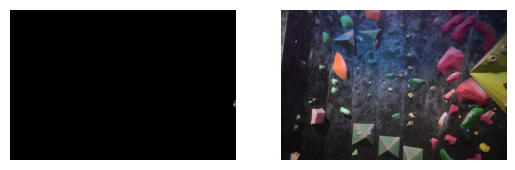

In [8]:
triplet_model.eval()


def hold_from_ids(read_path, image_idx, hold_idx):
    hold = cv2.imread(os.path.join(*read_path, "holds", f"{image_idx}-{hold_idx}.jpg"))
    hold = torch.tensor(hold).permute(2, 0, 1)
    hold = triplet_model.preprocess(hold).to(device).unsqueeze(0)
    return hold


correct = 0
total = 0
for img1, img2, img3 in tqdm(test_loader):
    with torch.no_grad():
        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
        output1 = triplet_model(img1)
        output2 = triplet_model(img2)
        output3 = triplet_model(img3)
        pos_dist = nn.functional.pairwise_distance(output1, output2).square()
        neg_dist = nn.functional.pairwise_distance(output1, output3).square()
        correct += (pos_dist < neg_dist).sum().item()
    total += output1.shape[0]

print(correct / total)

for image_idx, image_obj in enumerate(d_dict_test):
    read_path = image_obj["file_name"].split("/")[:-1]
    routes_dict = defaultdict(list)
    valid_hold_idx = []
    for hold_idx, poly in enumerate(image_obj["annotations"]):
        if poly["category_id"] == 1:
            # Volumes are considered part of the wall, not part of a route -> skip
            continue
        if poly["route_id"] is None:
            continue
        valid_hold_idx.append(hold_idx)

    start_node_idx = random.choice(valid_hold_idx)
    routes_dict[0] = [start_node_idx]
    for hold_idx, poly in enumerate(image_obj["annotations"]):
        if poly["category_id"] == 1:
            # Volumes are considered part of the wall, not part of a route -> skip
            continue
        if poly["route_id"] is None:
            continue
        if hold_idx == start_node_idx:
            continue
        for route_id, holds in routes_dict.items():
            dists = []
            for random_hold_idx in holds:
                with torch.no_grad():
                    output1 = triplet_model(
                        hold_from_ids(read_path, image_idx, hold_idx)
                    )
                    output2 = triplet_model(
                        hold_from_ids(read_path, image_idx, random_hold_idx)
                    )
                dist = nn.functional.pairwise_distance(output1, output2).square().item()
                dists.append(dist)
            if np.median(np.array(dists)) <= 0.7 and np.max(dists) <= 2.65:
                # Current hold is similar to all holds in existing route => Adding it to that route
                routes_dict[route_id].append(hold_idx)
                break
        else:
            # Current hold is not similar to any holds on existing routes => Add new route
            routes_dict[max(routes_dict.keys()) + 1].append(hold_idx)
    print(routes_dict)
    figures_axes = plot_routes(routes_dict, image_obj)
    for fig, ax in figures_axes:
        fig.canvas.draw()